This notebook illustrates two blogposts (in French) :
- "Peut-on toujours atteindre une maternité en 30 minutes ?" https://www.smalsresearch.be/peut-on-toujours-atteindre-une-maternite-en-30-minutes/
- [Blog post to be published in September 2021]

Requires same packages as in "Spatial_Join" notebook, plus : 
    
    - conda install -c conda-forge dash
    - conda install -c conda-forge -c plotly jupyter-dash
    - conda install descartes
    - conda install openpyxl
    - conda install -c conda-forge flexpolyline
    - conda install -c conda-forge python-kaleido


In [1]:
%matplotlib inline

In [2]:
import urllib
import time
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import contextily as ctx
import shapely
from shapely.geometry import shape
from pyproj import CRS

import os

import requests

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
import json
tqdm.pandas()

In [3]:
import shapely
import plotly.express as px
import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

import flexpolyline as fp


In [4]:
from credentials import here_api_key, here_app_code, here_app_id

In [5]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [6]:
try : os.mkdir("output")
except FileExistsError: pass

In [7]:
from_files = False 
# If False, Here API is called for geocoding and isolines, and result is stored in a file
# If True, API is not called, data is retreived from the file and plots are produced

In [8]:
add_options={}
option=None

In [9]:
dataset=  "smur"
# dataset = "maternity"
# dataset = "vaccin"

In [10]:
# Uncomment to two following lines to add traffic
# add_options = {"departureTime" : "2021-05-28T14:00:00+01:00"} # with heavy traffic
# option="traffic"
# # Could also be {"transportMode":"pedestrian"}

# Functions

## Geocoding

In [11]:
def get_geocode(addr):
    """
    Geocode an address with Here API

    Parameters
    ----------
    addr: str
       address to geocode
    filename: str
       local file to save

    Returns
    -------

    (lat, lon): (float, float)
        geographical coordinates (in epsg:4326)
    """

    host_name = "geocoder.api.here.com"
    
    params = urllib.parse.urlencode({"app_id": here_app_id,
                                     "app_code": here_app_code,
                                    "searchtext":addr,
                                    })
    
    url = f"https://{host_name}/6.2/geocode.json?{params}"
    
#     print(url)
    with urllib.request.urlopen(url) as response:
        res = response.read()
        res = json.loads(res)
        r = res["Response"]["View"][0]["Result"][0]["Location"]["DisplayPosition"]
        return r["Latitude"], r["Longitude"]

In [12]:
def geocode_points(starts):
    """
    Geocode all addresses in a geopandas GeoDataFrame. Add columns "lat", "lon" (in epsg:4326), 
    as well as "geometry" (in epsg:3857)

    Parameters
    ----------
    starts: geopandas.GeoDataFrame
       a dataframe which contains a column "address"

    Returns
    -------
        geopandas.GeoDataFrame, with 3 additionnal columns : "lat", "lon", and "geometry"
    """
    starts[["lat", "lon"]] = starts.address.progress_apply(get_geocode).apply(pd.Series)
    # Convert lat/long in xy points
    starts= starts.set_geometry(gpd.points_from_xy(x = starts["lon"], y=starts["lat"]))
    
    # Set CRS
    starts.crs = CRS(osm_crs)
    starts = starts.to_crs(CRS(crs))
    return starts

## Isolines

In [13]:
def get_isoline(lat, lon, range_list, add_options={}):
    """
    Get isolines 'lat, lon' as origin points, for all delays given in 'range_list' in minutes.
    Call Here isoline API, with some default parameters that can be overwritten or enriched with 'add_options'

    If 'Too Many Requests' error is received from Here, wait for 15 seconds and retries
    
    Parameters
    ----------
    lat: float
        Latitude (in epsg:4326)
    lon: float
        Longitude (in epsg:4326)
    range_list: list
        List of range values (in minutes)
    add_options : dict
        Example:  {"departureTime" : "2021-05-28T14:00:00+01:00", "transportMode":"pedestrian"}
    
    Returns
    -------
        A dict, with keys from range_list, and data is a list of coordinates tuple. 
        Example : 
            {10.0: [(50.818634, 4.257374),
                    (50.818291, 4.258232),
                    (50.817604, 4.258919),
                    (...)],
             15.0: (50.821381, 4.266815),
                   (50.821037, 4.267845),
                   (50.820351, 4.268532),
                   (...)]}
    """

    
    host_name = "isoline.router.hereapi.com"
    
    
    params = {"apiKey": here_api_key,
                "transportMode":f"car", 
                "departureTime":"any", # No traffic dependent
                "origin" : f"{lat},{lon}",
                "range[values]" :",".join([str(rng*60) for rng in range_list]),
                "range[type]":"time"#  "distance"
                }
    for k in add_options:
        params[k] = add_options[k]
        
    params = urllib.parse.urlencode(params)
    
    url = f"https://{host_name}/v8/isolines?{params}"
    
#     print(url)
    try: 
        with urllib.request.urlopen(url) as response:
            res = response.read()
            res = json.loads(res)
#             print(res)
    #         return res
            for it in res["isolines"]:
                if len(it["polygons"]) != 1:
                    print("More than 1 polygon!!")

            return {it["range"]["value"]/60: fp.decode(it["polygons"][0]["outer"]) for it in res["isolines"]} #["isoline"][0]["component"][0]["shape"]
    except urllib.error.HTTPError as ex:
        if ex.getcode() == 429:  #Too Many Requests
            print("Too many requests, wait for 15 seconds...")
            time.sleep(15)
            return get_isoline(lat, lon, range_list)
        else:
            print(ex)
            print(type(ex))
            print(url)
            return None

In [14]:
# get_isoline(50.83458, 4.33639, [10])

In [15]:
def get_isolines(starts, range_list, add_options={}):
    """
    From the output of geocode_points(starts), call get_isoline for each record, with range_list and add_options as parameter.
    
    Note: does NOT support multi-component isolines (https://developer.here.com/documentation/isoline-routing-api/8.4.0/dev_guide/topics/multi-component-isoline.html)
    
    Parameters
    ----------
    start: geopandas.GeoDataFrame
        output of geocode_points(starts)
    range_list: list
        list of range values (in minutes)
    add_options : dict
        Example:  {"departureTime" : "2021-05-28T14:00:00+01:00", "transportMode":"pedestrian"}
    
    Returns
    -------
    geopandas.GeoDataFrame
        A geopandas.GeoDataFrame, with starts.shape[0] * len(range_list) record. For each starting point and each range, 
        "geometry" columns is a polygon with the corresponding isoline
        

    """

    isolines= starts.copy()
    isolines["isolines"] = isolines.progress_apply(lambda row: get_isoline(row["lat"], row["lon"], range_list, add_options), axis=1)
    
    

    for rng in range_list:
        isolines[rng] = isolines["isolines"].apply(lambda x: x[rng])
    
    isolines =  isolines.drop(["geometry", "isolines"], axis=1)
    cols= isolines.drop(range_list, axis=1).columns
    
    isolines = isolines.set_index(list(cols)).stack().rename("isoline").reset_index().rename(columns={"level_7": "range",
                                                                                                      "level_8": "range",
                                                                                                      "level_9": "range",
                                                                                                     })

    # Convert isolines to polygons
    isolines["geometry"] = isolines["isoline"].apply(lambda row:Polygon(map(lambda tpl: (tpl[1], tpl[0]), row)))
    isolines = isolines.set_geometry("geometry")

    isolines.crs = CRS(osm_crs)
    isolines = isolines.to_crs(CRS(crs))
    return isolines.drop("isoline", axis=1)

In [16]:
def get_isolines_grouped(isolines, subsets):
    """
    From the output of get_isolines(starts), group all isolines for the same range, making a (multi)polygon from all the 
    (single starting points) polygons
    
    Parameters
    ----------
    isolines: geopandas.GeoDataFrame
        output of get_isolines
    subsets: list
        list of scenarii (corrsponding to boolean columns in isolines dataframe)
    
    Returns
    -------
    geopandas.GeoDataFrame
        A geopandas.GeoDataFrame, with len(subsets) * len(range_list) record. For each scenario point and each range, 
        "geometry" columns is a (mutli)polygon with the corresponding reachable region

    """

    
    isolines_grouped = []
    for subset in subsets:
        gr = isolines[isolines[subset]].groupby("range").apply(lambda bloc: bloc.unary_union).rename("geometry").reset_index()
        gr["subset"]=subset
        isolines_grouped.append(gr)
        
    isolines_grouped = gpd.GeoDataFrame(pd.concat(isolines_grouped))
    isolines_grouped.crs = CRS(crs)

    isolines_grouped["label"] = isolines_grouped.apply(lambda x: f"{x['subset']} ({x['range']})", axis=1)
    
    return isolines_grouped

In [17]:
# get_isolines_grouped(isolines, subsets)

## Plot

In [55]:
def add_basemap(ax, alpha=None):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
        ctx.add_basemap(ax, alpha=alpha)
    except requests.HTTPError:
        print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=alpha)

In [19]:
def disjoin_labels(geo_df):
    """
    From the output of get_isolines_grouped, filtred on a unique range (we should then have len(subsets) records, 
    extract the overlapping regions.
    
    Example :
     geo_df= [["subs1", geom1],
              ["subs2", geom2]]
    if geom2 in full included in geom1, output will be: 
        [["subs1",          geom1-geom2],
         ["all scenarii",   geom2]]
         
    if there is an ovelapping region "common":
        [["subs1",        geom1-common],
         ["subs2",        geom2-common],
         ["all scenarii", common]]
    
    If more than 2 subsets, extracts also overlappings two by two
    Parameters
    ----------
    geo_df: geopandas.GeoDataFrame
    
    Returns
    -------
        None
    """

    ## Find global common zone (common to all zones)
    
    common_zone =  geo_df.iloc[[0]]
    
    for i in range(1, geo_df.shape[0]):
        common_zone = gpd.overlay(common_zone, 
                              geo_df.iloc[[i]], 
                              how="intersection", 
                              keep_geom_type=False)
    common_zone = common_zone.geometry
    
    if common_zone.shape[0]>0:
        common_zone_s = gpd.GeoSeries([common_zone.iloc[0] for it in geo_df.iterrows()])
        common_zone_s.crs= geo_df.crs


        geo_df = geo_df.reset_index(drop=True).copy()

        geo_df["common_zone"] = common_zone_s
        try: 
            geo_df["geometry"]= geo_df.geometry.difference(geo_df["common_zone"])#.plot()
        except shapely.errors.TopologicalError as e:
            print(e)
            print("Trying with buffer(0)...")
            geo_df["geometry"]= geo_df.geometry.buffer(0).difference(geo_df["common_zone"])
            
            #return geo_df#.drop("common_zone", axis=1)

        m_range =  geo_df.range.iloc[0]

        geo_df = geo_df.append({"subset": "all scenarii", 
                                "label" : f"all scenarii ({m_range})", 
                                "geometry":common_zone.iloc[0], 
                                "range": m_range,
                               "reach_ratio":0 # not correct!
                               }, ignore_index=True).drop("common_zone", axis=1).copy()
    ## Find one2one (remaining) overlaps (only if len(subsets)>2)
    
    sh = geo_df.shape[0]
    for i in range(sh):
        for j in range(i+1, sh):
            
            common_zone = geo_df.iloc[i].geometry.intersection(geo_df.iloc[j].geometry)
            
            if geo_df.iloc[i].geometry.area > 0 and common_zone.area/geo_df.area.max() > 0.01:
                
                geo_df["geometry"].iloc[i] = geo_df.iloc[i].geometry.difference(common_zone)
                geo_df["geometry"].iloc[j] = geo_df.iloc[j].geometry.difference(common_zone)
                
                geo_df = geo_df.append({"subset": f"{geo_df.iloc[i].subset} + {geo_df.iloc[j].subset}", 
                                "label" : f"{geo_df.iloc[i].subset} + {geo_df.iloc[j].subset} ({m_range})", 
                                "geometry":common_zone, 
                                "range": m_range,
                               "reach_ratio":0 # not correct!
                               }, ignore_index=True).copy()
                #common_zone.plot()
            
    geo_df = geo_df[~geo_df.geometry.is_empty & (geo_df.area/geo_df.area.max() > 0.01)]
    return geo_df

In [80]:
# from matplotlib import cm
from matplotlib.colors import ListedColormap
def plot_isolines(isolines_grouped, starts, m_range, boundary):
    
    geo_df = isolines_grouped[(isolines_grouped.range == m_range)]
    
    geo_df = disjoin_labels(geo_df).sort_values("label")
#     display(geo_df)
    cmap =    ListedColormap( [f"C{i}" for i in range(geo_df.label.nunique())])
    cmap_st = ListedColormap( [f"C{i}" for i in range(starts.label.nunique())])
    
    ax=  geo_df.plot("label", alpha=0.2, figsize=(10, 10), cmap=cmap)
    ax = geo_df.plot("label", ax=ax, facecolor="none", edgecolor="k", cmap=cmap, legend=True)
    
    starts.sort_values("label").plot("label", ax=ax, cmap=cmap_st)
    boundaries.boundary.plot(ax=ax, color="black")
#     boundaries.boundary.plot(ax=ax, color="C2", linewidth=5)
    
    minx, miny, maxx, maxy = boundaries.total_bounds
    width = maxx-minx
    height = maxy-miny
    ax.set_xlim(minx - width/10,  maxx + width/10)
    ax.set_ylim(miny - height/10, maxy + height/10)
    
    ax.set_title(f"Reached zone ({dataset}{', '+option if option else ''}) - range: {m_range} minutes")
    add_basemap(ax)#, alpha=0.5)
    
    
    return ax

In [119]:
# ax= isolines[isolines.range == minute_range[5]].plot("name", alpha=0.8, figsize=(10, 10), legend=True)
# boundaries.boundary.plot(ax=ax, color="C2", linewidth=5)
# add_basemap(ax)

# ax = plot_isolines(isolines_grouped, starts, minute_range[10], boundaries)
# plt.axis("off")

In [22]:
# ax = plot_isolines(isolines_grouped, starts, minute_range[1], boundaries)

In [23]:
def plot_isolines_px(isolines_grouped, starts, m_range, boundary):
    geo_df = isolines_grouped[(isolines_grouped.range == m_range)]
    
    geo_df.crs = CRS(crs)
    geo_df = geo_df.to_crs(osm_crs)
    
    bnd = boundaries.copy()
    bnd.crs = CRS(crs)
    bnd = bnd.to_crs(osm_crs)

#     display(geo_df)
    geo_df = disjoin_labels(geo_df)
    
    #display(geo_df)
    fig = px.choropleth_mapbox(geo_df, 
                           geojson=geo_df.geometry, 
                           locations=geo_df.index, 
                           hover_name="label",
                           hover_data=["label"],
                           color=geo_df['label'],
                           labels={"label": "Scenario"},
                           center={"lat": bnd.bounds[["miny","maxy"]].mean(axis=1).iloc[0], 
                                   "lon": bnd.bounds[["minx","maxx"]].mean(axis=1).iloc[0]},
#                            mapbox_style="carto-positron",
                           mapbox_style="open-street-map",
                           zoom=zoom,
                           width=950, height=800,
                           opacity=0.5,
                           title= f"Reached zone ({dataset}{', '+option if option else ''}) - range: {m_range} minutes"
                           
                   )
    
    #fig.update_geos(fitbounds="locations")
    
    starts_df =  starts.to_crs(osm_crs)
    
    fig.add_trace(go.Scattermapbox(
                            lat=starts_df.lat,
                            lon=starts_df.lon,
                            text=starts_df.name, 
                            name="Starts")
                       )
    
    
    if isinstance(bnd.geometry.iloc[0], shapely.geometry.MultiPolygon):
        # Get the main polygon
        bnd_coords = pd.DataFrame(max(bnd.geometry.iloc[0], key=lambda a: a.area).exterior.coords)
#         print(bnd)
    else: 
        bnd_coords = pd.DataFrame(bnd.geometry.iloc[0].exterior.coords)
    #[(x, y) for (x, y) in bnd.geometry.iloc[0].exterior.coords])
    
    fig.add_trace(go.Scattermapbox(lat=bnd_coords[1],
                            lon=bnd_coords[0],
                            mode='lines',
                            name="Boundary"))
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    ))

    return fig

## Other

In [24]:
import os
def download_if_nexist(url, filename):
    """
    If the (local) file <filename> does not exists, download it from <url> 

    Parameters
    ----------
    url: str
       url to fetch
    filename: str
       local file to save

    Returns
    -------

    None
    """
    if not os.path.isfile(filename):
        with urllib.request.urlopen(url) as response:
            with open(filename, "wb") as f:
                f.write(response.read())

# Prepare starting points data

In [25]:
dataset_label=f"{dataset}{'_'+option if option else ''}"

In [26]:
output_path=f"output/{dataset_label}"
try : os.mkdir(output_path)
except FileExistsError: pass

In [27]:
boundaries_filename = "data/boundaries.geojson"
if not os.path.isfile(boundaries_filename):
    zipcode_boundaries_filename = "data/zipcode_boundaries_shapefile_3812.zip"
    # https://www.geo.be/catalog/details/9738c7c0-5255-11ea-8895-34e12d0f0423?l=fr
    download_if_nexist("https://bgu.bpost.be/assets/9738c7c0-5255-11ea-8895-34e12d0f0423_x-shapefile_3812.zip",
                      zipcode_boundaries_filename)
    zipcodes_boundaries = gpd.read_file(f"zip://{zipcode_boundaries_filename}/3812")
    
    bru = Polygon(zipcodes_boundaries[zipcodes_boundaries.nouveau_PO.between("1000", "1299")].unary_union.exterior)
    bel = Polygon(max(zipcodes_boundaries.unary_union, key=lambda a: a.area).exterior)

    all_boundaries= gpd.GeoDataFrame([{"name":"BRU", "geometry": bru},
                                      {"name":"BEL", "geometry": bel}
                                  ])
    all_boundaries = all_boundaries.set_geometry("geometry")
    all_boundaries.crs = zipcodes_boundaries.crs
    all_boundaries = all_boundaries.to_crs(CRS(crs))
    
    all_boundaries.to_file(boundaries_filename, driver="GeoJSON")
else:
    
    all_boundaries = gpd.read_file(boundaries_filename)


<AxesSubplot:>

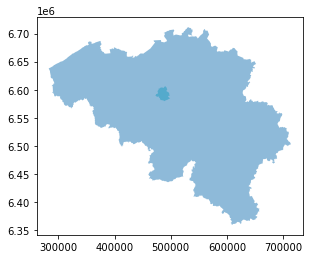

In [28]:
all_boundaries.plot("name", alpha=0.5)

## Smur Bxl

In [29]:
if dataset == "smur":
    starts = gpd.GeoDataFrame(columns = 
    ["name",             "address",                                      "wk_xl", "wk_dlt", "wk_stjean", "wk_none"], data=[
    ["Paul Brien",       "Av. Britsiers 5, 1030 Schaerbeek",             True,    True,    True,    True ],
    ["Saint-Pierre",     "Rue Haute 290, 1000 Bruxelles",                True,    True,    True,    True ],
    ["Sainte-Elisabeth", "Avenue De Fré 206, 1180 Uccle",                True,    True,    True,    True ],
    ["Saint-Luc",        "Avenue Hippocrate, 1200 Woluwe-Saint-Lambert", True,    True,    True,    True ],
    ["Érasme (ULB)",     "Rue Meylemeersch 56, 1070 Anderlecht",         True,    True,    True,    True ],
    ["HM",               "Rue Bruyn 1, 1120 Bruxelles",                  True,    True,    True,    True ],
    ["AZVUB",            "Avenue du Laerbeek 101, 1090 Jette",           True,    True,    True,    True ],
    ["Ixelles",          "Rue Jean Paquot 63, 1050 Ixelles",             True,    False,   False,   False],
    ["Delta",            "Boulevard du Triomphe 201, 1160 Auderghem",    False,   True,    False,   False],
    ["Saint-Jean",       "Rue du Marais 104, 1000 Bruxelles",            False,   False,   True,    False],

    ])


    subsets = ["wk_xl", "wk_dlt", "wk_stjean"] #, "wk_none"
    minute_range = list(range(16)) # list(range(21)) #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18]
    


In [30]:
if dataset == "smur":
    boundaries = all_boundaries[all_boundaries.name == "BRU"]
    zoom = 10.5

## Maternities

In [31]:
if dataset == "maternity":
    starts = pd.read_csv("data/maternities.csv", usecols=["name", "address"])
    starts = gpd.GeoDataFrame(starts)

    starts["current"] = True


In [32]:
# https://kce.fgov.be/fr/une-r%C3%A9duction-du-nombre-de-maternit%C3%A9s-est-possible-dans-notre-pays
# From https://www.google.com/maps/d/u/0/viewer?mid=1BuSrXrmRLzqMNVNLR-hSq0PL53o9GaB9&ll=50.83934807412515%2C4.471731899999895&z=9
# https://plus.lesoir.be/273299/article/2020-01-16/voici-les-17-maternites-belges-qui-pourraient-fermer-leurs-portes-carte

# AZ Sint-Jan (Ostende)
# AZ Zeno (Knokke-Heist)
# AZ Delta (Turnhout)
# Sint-Andries (Tielt)
# St. Vincentius (Deinze)
# A.Z. (Audenarde)
# AZ Delta (Menin)
# AZ Glorieux (Renaix)
# Site St-Joseph, du CHR de Mons
# CH Haute Senne, site le Tilleriau (Soignies)
# CHU André Vésale - site de Lobbes (Montigny-le-Tilleul)
# C.H. Jolimont (Lobbes)
# CHR Sambre et Meuse (Auvelais)
# Centre Hospitalier Régional de Huy
# CHC - Clinique Sainte-Elisabeth (Verviers)
# St. Nikolaus Hospital (Eupen)
# ASZ (Grammont) - déjà fermé depuis l'été
if dataset == "maternity":
    should_go_names = ["ST. JAN BRUGGE", "Zeno", "Torhout", "Tielt", "Deinze", "Oudenaarde", "Menen", "Glorieux", 
                       "CHR Mons", "Tilleriau", "Vesale", "Lobbes", "Sambre", "Huy", "VERVIERS, CENTRE HOSPITALIER CHRETIEN", 
                       "Eupen"]

    starts["future"] = starts.name.str.upper().apply(lambda x: sum([sgn.lower() in x.lower() for sgn in should_go_names]) == 0)
    assert starts[~starts.future].shape[0] ==  len(should_go_names)

    subsets = ["current", "future"]
    minute_range = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

In [33]:

if dataset == "maternity":
    boundaries = all_boundaries[all_boundaries.name == "BEL"]
    zoom = 7

## Covid Vaccin

In [34]:
if dataset == "vaccin":
    starts = gpd.GeoDataFrame(columns = 
    ["name",        "address",                                            "current", "with_WB"], data=[
    ["Pachéco",     "Boulevard Pachéco, 42, 1000 Bruxelles",               True,    True],
    ["Heysel ",     "Avenue Impératrice Charlotte, 6, 1020 Laeken",        True,    True],
    ["WSP",         "Drève des Shetlands, 15, 1150 Woluwé-Saint-Pierre",   True,    True],
    ["Schaerbeek",  "Avenue du Suffrage Universel, 1030 Schaerbeek",       True,    True],
    ["Molenbeek",   "Chaussée de Gand, 696, 1080 Molenbeek",               True,    True],
    ["Forest",      "Avenue Jupiter, 201, 1190 Forest",                    True,    True],
    ["Anderlecht",  "Avenue Théo Verbeeck, 2, 1070 Anderlecht",            True,    True],
    ["WSL",         "Avenue des Vaillants, 2, 1200 Woluwé-Saint-Lambert",  True,    True],
    ["Uccle",       "Rue Égide Van Ophem, 110, 1180 Uccle",                True,    True],
    ["HM",          "Rue Bruyn, 200 à 1120 Neder-over-Heembeek",           True,    True],
    ["Watermael",   "Boulevard du Souverain 25, 1170 Watermael-Boitsfort", False,   True]
    ])
    subsets = ["current", "with_WB"]
    minute_range = list(range(21)) #[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [35]:
if dataset == "vaccin":
    boundaries = all_boundaries[all_boundaries.name == "BRU"]
    zoom = 10.5


## Add label

In [36]:
starts["label"] = starts.apply(lambda row: ";".join(sb for sb in subsets if row[sb]), axis=1)
starts["label"] = starts["label"].str.replace(";".join(subsets), "all scenarii")

In [37]:
starts

name                                       address  wk_xl  \
0        Paul Brien              Av. Britsiers 5, 1030 Schaerbeek   True   
1      Saint-Pierre                 Rue Haute 290, 1000 Bruxelles   True   
2  Sainte-Elisabeth                 Avenue De Fré 206, 1180 Uccle   True   
3         Saint-Luc  Avenue Hippocrate, 1200 Woluwe-Saint-Lambert   True   
4      Érasme (ULB)          Rue Meylemeersch 56, 1070 Anderlecht   True   
5                HM                   Rue Bruyn 1, 1120 Bruxelles   True   
6             AZVUB            Avenue du Laerbeek 101, 1090 Jette   True   
7           Ixelles              Rue Jean Paquot 63, 1050 Ixelles   True   
8             Delta     Boulevard du Triomphe 201, 1160 Auderghem  False   
9        Saint-Jean             Rue du Marais 104, 1000 Bruxelles  False   

   wk_dlt  wk_stjean  wk_none         label  
0    True       True     True  all scenarii  
1    True       True     True  all scenarii  
2    True       True     True  all scenarii  
3    True       True     True  all scenarii  
4    True       True     True  all scenarii  
5    True       True     True  all scenarii  
6    True       True     True  all scenarii  
7   False      False    False         wk_xl  
8    True      False    False        wk_dlt  
9   False       True    False     wk_stjean

In [38]:
starts.label.value_counts()

all scenarii    7
wk_xl           1
wk_dlt          1
wk_stjean       1
Name: label, dtype: int64

## Geocoding

In [39]:
if not from_files:
    starts = geocode_points(starts)
    starts.to_pickle(f"data/starts_{dataset_label}.pkl.gz")
else: 
    starts = pd.read_pickle(f"data/starts_{dataset_label}.pkl.gz")
    
    # fixing a bug that makes geodataframe being loaded from pickle to be not plottable
    # after loading from pickle: starts.name.dtype is np.dtype("O") == False
    n = starts.name.str.replace("willnotappear", "").copy()
    starts = starts.drop("name", axis=1).assign(name=n)
    # after those lines : # starts.name.dtype is np.dtype("O") == True
    
starts

  0%|          | 0/10 [00:00<?, ?it/s]

name                                       address  wk_xl  \
0        Paul Brien              Av. Britsiers 5, 1030 Schaerbeek   True   
1      Saint-Pierre                 Rue Haute 290, 1000 Bruxelles   True   
2  Sainte-Elisabeth                 Avenue De Fré 206, 1180 Uccle   True   
3         Saint-Luc  Avenue Hippocrate, 1200 Woluwe-Saint-Lambert   True   
4      Érasme (ULB)          Rue Meylemeersch 56, 1070 Anderlecht   True   
5                HM                   Rue Bruyn 1, 1120 Bruxelles   True   
6             AZVUB            Avenue du Laerbeek 101, 1090 Jette   True   
7           Ixelles              Rue Jean Paquot 63, 1050 Ixelles   True   
8             Delta     Boulevard du Triomphe 201, 1160 Auderghem  False   
9        Saint-Jean             Rue du Marais 104, 1000 Bruxelles  False   

   wk_dlt  wk_stjean  wk_none         label        lat       lon  \
0    True       True     True  all scenarii  50.869380  4.385800   
1    True       True     True  all scenarii  50.835730  4.348100   
2    True       True     True  all scenarii  50.805300  4.370630   
3    True       True     True  all scenarii  50.854470  4.447360   
4    True       True     True  all scenarii  50.812280  4.264400   
5    True       True     True  all scenarii  50.907530  4.390220   
6    True       True     True  all scenarii  50.886120  4.309440   
7   False      False    False         wk_xl  50.824562  4.379648   
8    True      False    False        wk_dlt  50.816680  4.399960   
9   False       True    False     wk_stjean  50.853920  4.360510   

                         geometry  
0  POINT (488225.023 6598221.000)  
1  POINT (484028.278 6592287.540)  
2  POINT (486536.306 6586925.541)  
3  POINT (495077.851 6595591.411)  
4  POINT (474710.837 6588155.162)  
5  POINT (488717.055 6604953.121)  
6  POINT (479724.666 6601174.337)  
7  POINT (487540.174 6590319.230)  
8  POINT (489801.307 6588930.375)  
9  POINT (485409.753 6595494.427)

In [40]:
fig = px.scatter_mapbox(starts,
                        lat="lat",
                        lon="lon",
                        hover_name="name",
                        color='label',
                        size_max=120,
                        zoom=10,
                        mapbox_style="open-street-map",
                        #opacity=0.2
                   )

bd = boundaries.to_crs(osm_crs)
fig_bd = px.choropleth_mapbox(bd, 
                           geojson=bd.geometry, 
                           locations=bd.index, 
                           #labels="boundary",
                           #hover_name="name",
                           #fill_color="none",
                           
                           #zoom=10,
                           opacity=0.2
                   )



fig.add_trace(fig_bd.data[0])


fig.show()

(471086.2557179927, 500291.65850749245, 6578273.415749143, 6607401.994184209)

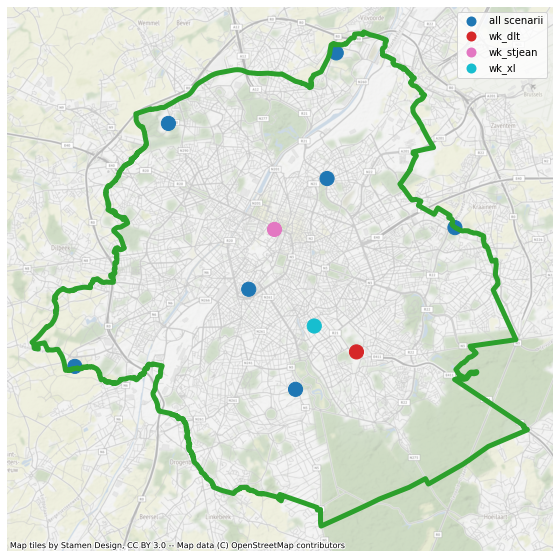

In [60]:
ax = starts.plot("label", legend=True, figsize=(10,10), markersize=200)
boundaries.boundary.plot(ax=ax, color="C2", linewidth=5)
add_basemap(ax, alpha=0.5)
plt.axis("off")

# Multirange process

In [61]:
if not from_files:
    isolines = get_isolines(starts, minute_range, add_options)
    isolines.to_pickle(f"data/isolines_{dataset_label}.pkl.gz")

else :
    isolines = pd.read_pickle(f"data/isolines_{dataset_label}.pkl.gz")
    # fixing a bug that makes geodataframe being loaded from pickle to be not plottable
    n = isolines.name.str.replace("willnotappear", "").copy()
    isolines = isolines.drop("name", axis=1).assign(name=n)
    
    
isolines


  0%|          | 0/10 [00:00<?, ?it/s]

Too many requests, wait for 15 seconds...


name                            address  wk_xl  wk_dlt  wk_stjean  \
0    Paul Brien   Av. Britsiers 5, 1030 Schaerbeek   True    True       True   
1    Paul Brien   Av. Britsiers 5, 1030 Schaerbeek   True    True       True   
2    Paul Brien   Av. Britsiers 5, 1030 Schaerbeek   True    True       True   
3    Paul Brien   Av. Britsiers 5, 1030 Schaerbeek   True    True       True   
4    Paul Brien   Av. Britsiers 5, 1030 Schaerbeek   True    True       True   
..          ...                                ...    ...     ...        ...   
155  Saint-Jean  Rue du Marais 104, 1000 Bruxelles  False   False       True   
156  Saint-Jean  Rue du Marais 104, 1000 Bruxelles  False   False       True   
157  Saint-Jean  Rue du Marais 104, 1000 Bruxelles  False   False       True   
158  Saint-Jean  Rue du Marais 104, 1000 Bruxelles  False   False       True   
159  Saint-Jean  Rue du Marais 104, 1000 Bruxelles  False   False       True   

     wk_none         label       lat      lon  range  \
0       True  all scenarii  50.86938  4.38580      0   
1       True  all scenarii  50.86938  4.38580      1   
2       True  all scenarii  50.86938  4.38580      2   
3       True  all scenarii  50.86938  4.38580      3   
4       True  all scenarii  50.86938  4.38580      4   
..       ...           ...       ...      ...    ...   
155    False     wk_stjean  50.85392  4.36051     11   
156    False     wk_stjean  50.85392  4.36051     12   
157    False     wk_stjean  50.85392  4.36051     13   
158    False     wk_stjean  50.85392  4.36051     14   
159    False     wk_stjean  50.85392  4.36051     15   

                                              geometry  
0    POLYGON ((488317.974 6598717.030, 488508.999 6...  
1    POLYGON ((487706.497 6599201.623, 487897.521 6...  
2    POLYGON ((487094.907 6599686.245, 487286.043 6...  
3    POLYGON ((487094.907 6600655.397, 487286.043 6...  
4    POLYGON ((486177.746 6598717.030, 486368.770 6...  
..                                                 ...  
155  POLYGON ((474559.331 6600655.397, 475132.515 6...  
156  POLYGON ((471807.513 6601139.928, 473909.559 6...  
157  POLYGON ((469361.601 6601624.664, 471463.536 6...  
158  POLYGON ((466609.895 6601139.928, 467794.668 6...  
159  POLYGON ((463170.122 6601261.154, 463284.781 6...  

[160 rows x 11 columns]

In [62]:
isolines_grouped = get_isolines_grouped(isolines, subsets)
isolines_grouped

range                                           geometry     subset  \
0       0  MULTIPOLYGON (((486617.235 6587097.114, 486712...      wk_xl   
1       1  MULTIPOLYGON (((485547.121 6586855.258, 485986...      wk_xl   
2       2  MULTIPOLYGON (((484782.690 6586855.258, 484916...      wk_xl   
3       3  MULTIPOLYGON (((473947.741 6589516.591, 475132...      wk_xl   
4       4  MULTIPOLYGON (((483062.915 6586673.827, 483082...      wk_xl   
5       5  MULTIPOLYGON (((470890.352 6589516.591, 471081...      wk_xl   
6       6  MULTIPOLYGON (((481992.801 6585948.142, 482050...      wk_xl   
7       7  MULTIPOLYGON (((481228.370 6585464.505, 481285...      wk_xl   
8       8  MULTIPOLYGON (((480616.892 6585706.320, 480674...      wk_xl   
9       9  POLYGON ((493458.328 6587671.704, 493477.410 6...      wk_xl   
10     10  POLYGON ((493630.363 6588790.655, 493936.047 6...      wk_xl   
11     11  POLYGON ((496152.752 6585887.730, 496038.093 6...      wk_xl   
12     12  POLYGON ((495388.432 6581293.303, 495426.615 6...      wk_xl   
13     13  POLYGON ((497490.431 6584013.379, 497490.367 6...      wk_xl   
14     14  POLYGON ((497757.979 6582018.578, 497757.979 6...      wk_xl   
15     15  POLYGON ((500662.527 6585645.909, 500815.368 6...      wk_xl   
0       0  MULTIPOLYGON (((486617.235 6587097.114, 486712...     wk_dlt   
1       1  MULTIPOLYGON (((485547.121 6586855.258, 485986...     wk_dlt   
2       2  MULTIPOLYGON (((474253.536 6589032.744, 474444...     wk_dlt   
3       3  MULTIPOLYGON (((473947.741 6589516.591, 475132...     wk_dlt   
4       4  MULTIPOLYGON (((472419.102 6589516.591, 473603...     wk_dlt   
5       5  MULTIPOLYGON (((470890.352 6589516.591, 471081...     wk_dlt   
6       6  MULTIPOLYGON (((481992.801 6585948.142, 482050...     wk_dlt   
7       7  MULTIPOLYGON (((481228.370 6585464.505, 481285...     wk_dlt   
8       8  MULTIPOLYGON (((480616.892 6585706.320, 480674...     wk_dlt   
9       9  POLYGON ((497452.184 6588790.744, 497375.708 6...     wk_dlt   
10     10  POLYGON ((498445.822 6587943.929, 498292.980 6...     wk_dlt   
11     11  POLYGON ((499974.736 6588427.974, 499821.731 6...     wk_dlt   
12     12  POLYGON ((500586.050 6588911.699, 500433.209 6...     wk_dlt   
13     13  POLYGON ((508153.327 6597263.774, 506624.576 6...     wk_dlt   
14     14  POLYGON ((508535.598 6596900.457, 508382.645 6...     wk_dlt   
15     15  POLYGON ((504178.664 6590968.654, 503872.870 6...     wk_dlt   
0       0  MULTIPOLYGON (((486617.235 6587097.114, 486712...  wk_stjean   
1       1  MULTIPOLYGON (((485547.121 6586855.258, 485986...  wk_stjean   
2       2  MULTIPOLYGON (((484782.690 6586855.258, 484916...  wk_stjean   
3       3  MULTIPOLYGON (((483712.576 6586855.258, 483808...  wk_stjean   
4       4  MULTIPOLYGON (((483062.915 6586673.827, 483082...  wk_stjean   
5       5  MULTIPOLYGON (((470890.352 6589516.591, 471081...  wk_stjean   
6       6  MULTIPOLYGON (((481992.801 6585948.142, 482050...  wk_stjean   
7       7  MULTIPOLYGON (((481228.370 6585464.505, 481285...  wk_stjean   
8       8  MULTIPOLYGON (((480616.892 6585706.320, 480674...  wk_stjean   
9       9  POLYGON ((490725.704 6590484.546, 490725.704 6...  wk_stjean   
10     10  POLYGON ((493477.396 6588790.655, 493936.047 6...  wk_stjean   
11     11  POLYGON ((495025.287 6587006.362, 494967.978 6...  wk_stjean   
12     12  POLYGON ((495388.432 6581293.303, 495426.615 6...  wk_stjean   
13     13  POLYGON ((496382.070 6582744.067, 496382.070 6...  wk_stjean   
14     14  POLYGON ((496840.706 6583227.569, 496840.706 6...  wk_stjean   
15     15  POLYGON ((498942.745 6580991.245, 498942.752 6...  wk_stjean   

             label  
0        wk_xl (0)  
1        wk_xl (1)  
2        wk_xl (2)  
3        wk_xl (3)  
4        wk_xl (4)  
5        wk_xl (5)  
6        wk_xl (6)  
7        wk_xl (7)  
8        wk_xl (8)  
9        wk_xl (9)  
10      wk_xl (10)  
11      wk_xl (11)  
12      wk_xl (12)  
13      wk_xl (13)  
14      wk_xl

## Some specific plots

(469125.4860977285, 500385.0284894098, 6578156.668547458, 6609853.685419591)

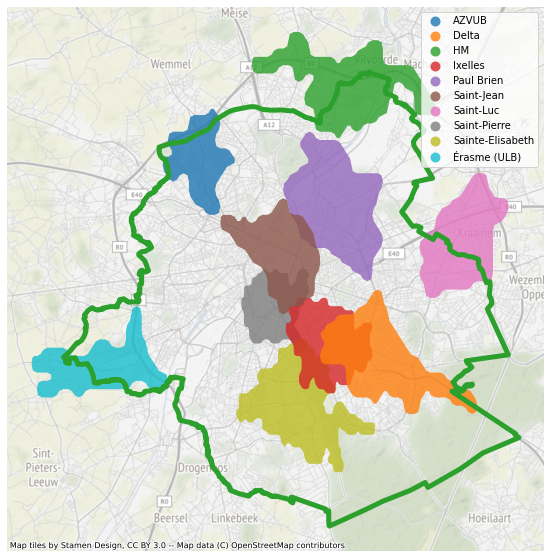

In [71]:
ax= isolines[isolines.range == minute_range[5]].plot("name", alpha=0.8, figsize=(10, 10), legend=True)
boundaries.boundary.plot(ax=ax, color="C2", linewidth=5)
add_basemap(ax, alpha=0.5)
plt.axis("off")

(486903.8997023283, 496993.53099351097, 6585766.571305314, 6593752.25634366)

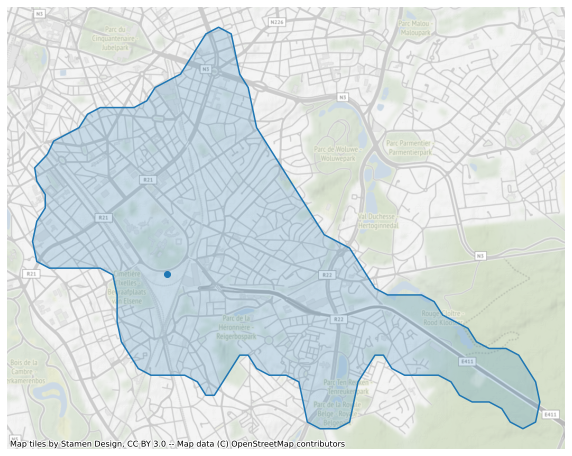

In [69]:
start_name= starts.name.iloc[-2]
sel = isolines[(isolines.name==start_name) & (isolines.range==minute_range[5])]
ax = sel.plot(alpha=0.2, figsize=(10, 10))
ax = sel.boundary.plot(ax=ax)
starts[(starts.name==start_name)].plot(ax=ax)
add_basemap(ax, alpha=0.5)#, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis("off")


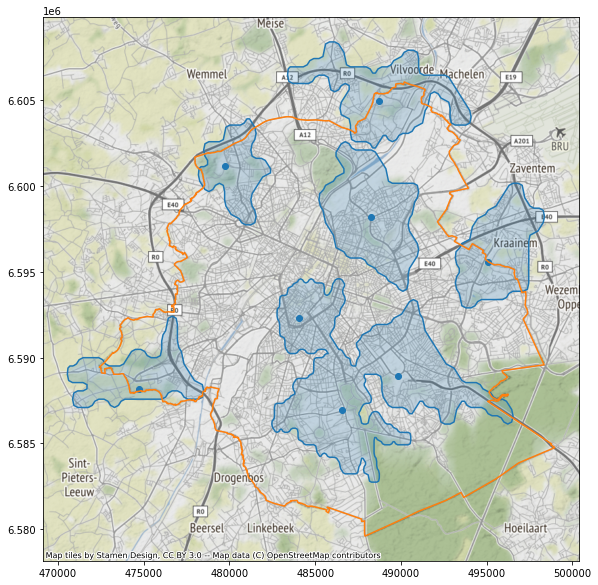

In [65]:
sel = isolines_grouped[(isolines_grouped.range == minute_range[5]) & 
                    (isolines_grouped.subset == subsets[1])]

ax= sel.plot("label", alpha=0.2, figsize=(10, 10), legend=False)
ax = sel.boundary.plot(ax=ax)
starts[starts[subsets[1]]].plot(ax=ax)
boundaries.boundary.plot(ax=ax, color="C1")
add_basemap(ax)

In [ ]:
# ax = plot_isolines(isolines_grouped, starts, minute_range[6], boundaries)

# Static images

In [72]:
plt.rcParams.update({'figure.max_open_warning': len(minute_range)})

In [73]:
for r in tqdm(minute_range):
    f = plot_isolines(isolines_grouped, starts, r, boundaries)
    plt.savefig(f"{output_path}/reached_zone_{dataset_label}_{r:02}.png")
    plt.close() # Remove this line to see all plots --> might be long! 

  0%|          | 0/16 [00:00<?, ?it/s]

'output/smur'

(469758.7374093791, 501619.1768161061, 6576949.38945664, 6608726.020476712)

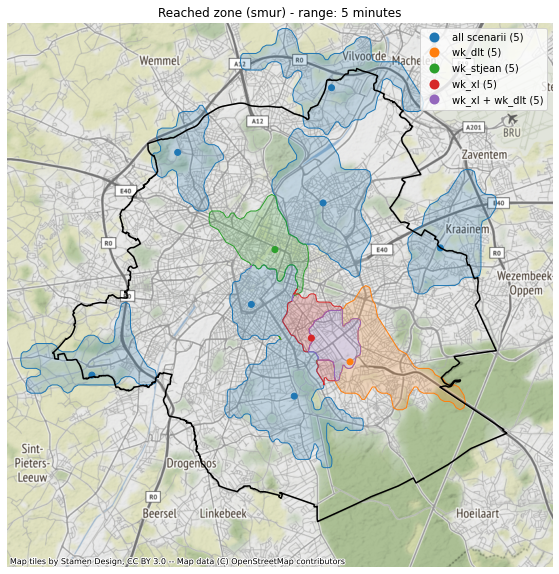

In [77]:
plot_isolines(isolines_grouped, starts, minute_range[5], boundaries)
plt.axis("off")

In [60]:
# Make a video from PNG images - Assumes ffmpeg is installed on the machine
print(f"Making {output_path}/reached_zone_{dataset_label}.mp4")
os.system(f"rm {output_path}/reached_zone_{dataset_label}.mp4")
os.system(f"cat {output_path}/reached_zone*.png | ffmpeg -f image2pipe -framerate 2 -i - -c:v libx264 -vf format=yuv420p -r 25 {output_path}/reached_zone_{dataset_label}.mp4")


Making output/smur/reached_zone_smur.mp4


0

# Dash dashboard

In [1]:
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1(f"Multipoint reachability ({dataset})"),
    dcc.Graph(id='graph'),
    html.Label([
        "Range",
        dcc.Slider(
            id='range-slider', 
            min=minute_range[0],
            max=minute_range[-1],
            step=None,
            marks={c: str(c) for c in minute_range},
            value=minute_range[-3]
            )
    ])
])

NameError: name 'JupyterDash' is not defined

In [85]:
# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("range-slider", "value")]#, Input('traffic-radio', 'value')]
)
def update_figure(m_range):#, traffic):
    
    return plot_isolines_px(isolines_grouped, starts, m_range, boundaries)#, traffic) 



In [86]:
ip = '10.1.0.45'
print(f"Watch outside Jupyter: http://{ip}:8050/")
app.run_server(mode='inline', debug=True, host=ip)

Watch outside Jupyter: http://10.1.0.45:8050/


In [87]:
plot_isolines_px(isolines_grouped, starts, minute_range[5], boundaries)

## Reach ratio

In [88]:
isolines_grouped_bnd = gpd.overlay(isolines_grouped, boundaries[["geometry"]], how="intersection")#.plot()

In [89]:
isolines_grouped_bnd["reach_ratio"] = isolines_grouped_bnd.area/boundaries.area.iloc[0]

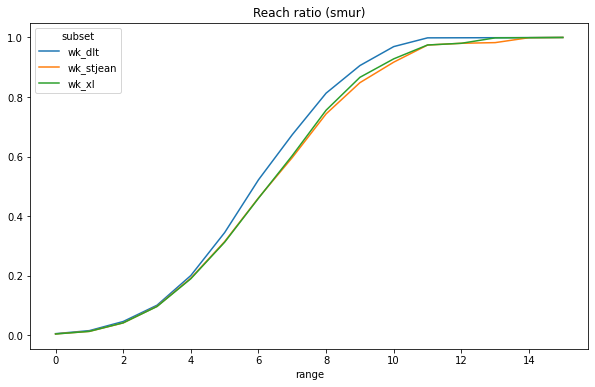

In [90]:
pv=isolines_grouped_bnd.pivot(index="range", values="reach_ratio", columns= "subset") #["label", "traffic"])#
fig=pv.plot(figsize=(10, 6), title=f"Reach ratio ({dataset}{', '+option if option else ''})")
plt.savefig(f"{output_path}/reach_ratio_{dataset_label}.png")

In [91]:
# With plotly
fig = px.line(pv,  title=f"Reach ratio ({dataset}{', '+option if option else ''})", 
             color_discrete_sequence=px.colors.qualitative.D3)
fig.update_layout(
    yaxis_title='Reached zone ratio',
    xaxis_title='Range (minutes)',
    title=f"Reach ratio ({dataset}{', '+option if option else ''})",
    hovermode="x",
    yaxis_tickformat= ',.2%'
)
fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))

fig.write_html(f"{output_path}/reach_ratio_{dataset_label}.html",  include_plotlyjs="cdn")
fig

# Population data

## Using statistical sectors

In [92]:
# https://statbel.fgov.be/fr/open-data/secteurs-statistiques-2020
download_if_nexist("https://statbel.fgov.be/sites/default/files/files/opendata/Statistische%20sectoren/sh_statbel_statistical_sectors_31370_20200101.shp.zip",
                   "data/stat_sectors_2020.zip")
statistical_sectors = gpd.read_file("zip://data/stat_sectors_2020.zip/sh_statbel_statistical_sectors_20200101.shp")
statistical_sectors = statistical_sectors.to_crs(crs)

In [93]:
#statistical_sectors.shape

In [94]:
# https://statbel.fgov.be/fr/nouvelles/la-population-par-secteur-statistique
download_if_nexist("https://statbel.fgov.be/sites/default/files/files/opendata/bevolking/sectoren/OPENDATA_SECTOREN_2020.xlsx",
                   "data/OPENDATA_SECTOREN_2020.xlsx")
population_per_sector = pd.read_excel("data/OPENDATA_SECTOREN_2020.xlsx")

In [95]:
pop_per_sector_geo = population_per_sector[["TX_DESCR_FR", "TX_DESCR_SECTOR_FR", "CD_SECTOR", "POPULATION"]]
pop_per_sector_geo = pop_per_sector_geo.merge(statistical_sectors[["CS01012020", "geometry"]].rename({"CS01012020":"CD_SECTOR"}, axis=1)).set_geometry("geometry")

<AxesSubplot:>

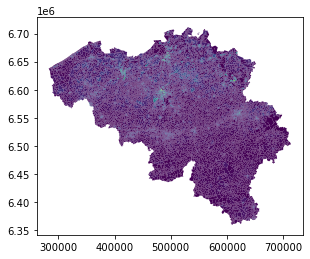

In [96]:
pop_per_sector_geo.plot("POPULATION")

## Using grid

It might be interessting to consider grid data, grouping population per 1km square. 
In this example, statistical sectors give a beter precision, so we do not use it.

In [97]:
# # https://statbel.fgov.be/fr/open-data/population-selon-la-grille-km2-grid-2020
# download_if_nexist("https://statbel.fgov.be/sites/default/files/files/opendata/Pop_GRID/TF_POPULATION_GRID_3035_20200101_geojson.zip",
#                    "data/pop_grid.zip")
# pop_per_sector_geo =  gpd.read_file("zip://data/pop_grid.zip/TF_POPULATION_GRID_3035_20200101.geojson")
# pop_per_sector_geo = pop_per_sector_geo[["geometry", "ms_population_20200101", "grd_floaid"]]
# pop_per_sector_geo = pop_per_sector_geo.rename(columns={"ms_population_20200101": "POPULATION",
#                                                         "grd_floaid": "CD_SECTOR"})
# pop_per_sector_geo = pop_per_sector_geo.to_crs(crs)
# pop_per_sector_geo

## Compute bounds

In [98]:
# Keep only sector within boundaries
pop_per_sector_geo = gpd.sjoin(pop_per_sector_geo, boundaries.buffer(100).reset_index().set_geometry(0), op="within")


In [99]:
# pop_per_sector_geo.POPULATION.sort_values()

In [100]:
# pop_per_sector_geo.area.sort_values().astype(int)#.hist()

<AxesSubplot:>

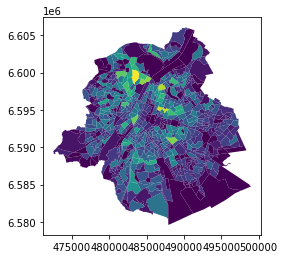

In [101]:
pop_per_sector_geo.plot("POPULATION")

In [102]:
# isolines_grouped_bnd.assign(geometry=isolines_grouped_bnd.buffer(10))

In [103]:
security_buffer = 10

In [104]:
isolines_grouped_pop = isolines_grouped_bnd
for op in ['intersects', 'contains']:
    isolines_grouped_op = gpd.sjoin(
                                    #isolines_grouped_bnd[["subset", "range", "geometry"]], 
                                    isolines_grouped_bnd.assign(geometry=isolines_grouped_bnd.buffer(security_buffer))[["subset", "range", "geometry"]], 
                                    pop_per_sector_geo[["geometry", "POPULATION"]],
                                    op=op)
    isolines_grouped_op = isolines_grouped_op.groupby(["subset", "range"]).POPULATION.sum().rename("POP_"+op).reset_index()
    
    isolines_grouped_pop = isolines_grouped_pop.merge(isolines_grouped_op, how="left")
isolines_grouped_pop

range     subset           label  \
0       0      wk_xl       wk_xl (0)   
1       1      wk_xl       wk_xl (1)   
2       2      wk_xl       wk_xl (2)   
3       3      wk_xl       wk_xl (3)   
4       4      wk_xl       wk_xl (4)   
5       5      wk_xl       wk_xl (5)   
6       6      wk_xl       wk_xl (6)   
7       7      wk_xl       wk_xl (7)   
8       8      wk_xl       wk_xl (8)   
9       9      wk_xl       wk_xl (9)   
10     10      wk_xl      wk_xl (10)   
11     11      wk_xl      wk_xl (11)   
12     12      wk_xl      wk_xl (12)   
13     13      wk_xl      wk_xl (13)   
14     14      wk_xl      wk_xl (14)   
15     15      wk_xl      wk_xl (15)   
16      0     wk_dlt      wk_dlt (0)   
17      1     wk_dlt      wk_dlt (1)   
18      2     wk_dlt      wk_dlt (2)   
19      3     wk_dlt      wk_dlt (3)   
20      4     wk_dlt      wk_dlt (4)   
21      5     wk_dlt      wk_dlt (5)   
22      6     wk_dlt      wk_dlt (6)   
23      7     wk_dlt      wk_dlt (7)   
24      8     wk_dlt      wk_dlt (8)   
25      9     wk_dlt      wk_dlt (9)   
26     10     wk_dlt     wk_dlt (10)   
27     11     wk_dlt     wk_dlt (11)   
28     12     wk_dlt     wk_dlt (12)   
29     13     wk_dlt     wk_dlt (13)   
30     14     wk_dlt     wk_dlt (14)   
31     15     wk_dlt     wk_dlt (15)   
32      0  wk_stjean   wk_stjean (0)   
33      1  wk_stjean   wk_stjean (1)   
34      2  wk_stjean   wk_stjean (2)   
35      3  wk_stjean   wk_stjean (3)   
36      4  wk_stjean   wk_stjean (4)   
37      5  wk_stjean   wk_stjean (5)   
38      6  wk_stjean   wk_stjean (6)   
39      7  wk_stjean   wk_stjean (7)   
40      8  wk_stjean   wk_stjean (8)   
41      9  wk_stjean   wk_stjean (9)   
42     10  wk_stjean  wk_stjean (10)   
43     11  wk_stjean  wk_stjean (11)   
44     12  wk_stjean  wk_stjean (12)   
45     13  wk_stjean  wk_stjean (13)   
46     14  wk_stjean  wk_stjean (14)   
47     15  wk_stjean  wk_stjean (15)   

                                             geometry  reach_ratio  \
0   MULTIPOLYGON Z (((486617.235 6587097.114 0.000...     0.004646   
1   MULTIPOLYGON Z (((485547.121 6586855.258 0.000...     0.013407   
2   MULTIPOLYGON Z (((484782.690 6586855.258 0.000...     0.042019   
3   MULTIPOLYGON Z (((473947.741 6589516.591 0.000...     0.096851   
4   MULTIPOLYGON Z (((472494.982 6589516.591 0.000...     0.190083   
5   MULTIPOLYGON Z (((472712.237 6589717.948 0.000...     0.312766   
6   MULTIPOLYGON Z (((472712.249 6589717.961 0.000...     0.460258   
7   MULTIPOLYGON Z (((493847.859 6599863.456 0.000...     0.603530   
8   MULTIPOLYGON Z (((476383.861 6597613.396 0.000...     0.755825   
9   POLYGON Z ((493458.328 6587671.704 0.000, 4934...     0.866238   
10  MULTIPOLYGON Z (((497631.138 6585740.195 0.000...     0.928253   
11  POLYGON Z ((496152.752 6585887.730 0.000, 4960...     0.974757   
12  POLYGON Z ((489682.282 6580405.144 0.000, 4896...     0.980481   
13  POLYGON Z ((497467.835 6584120.443 0.000, 4974...     0.998654   
14  POLYGON Z ((489588.838 6580361.678 0.000, 4895...     0.999275   
15  POLYGON Z ((497628.543 6584188.983 0.000, 4970...     1.000000   
16  MULTIPOLYGON Z (((486617.235 6587097.114 0.000...     0.005697   
17  MULTIPOLYGON Z (((485547.121 6586855.258 0.000...     0.015891   
18  MULTIPOLYGON Z (((474253.536 6589032.744 0.000...     0.046508   
19  MULTIPOLYGON Z (((473947.741 6589516.591 0.000...     0.101163   
20  MULTIPOLYGON Z (((472494.982 6589516.591 0.000...     0.200873   
21  MULTIPOLYGON Z (((472712.237 6589717.948 0.000...     0.345029   
22  MULTIPOLYGON Z (((472712.249 6589717.961 0.000...     0.522135   
23  MULTIPOLYGON Z (((493847.859 6599863.456 0.000...     0.673726   
24  MULTIPOLYGON Z (((476383.861 6597613.396 0.000...     0.813096   
25  POLYGON Z ((495744.934 6588548.750 0.000, 4956...     0.905713   
26  POLYGON Z ((489800.414 6580460.094 0.000, 4897...     0.969368   
27  POLYGON Z ((489800.414 6580460.094 0.000, 4897...     0.998704   
28  POLYGON Z

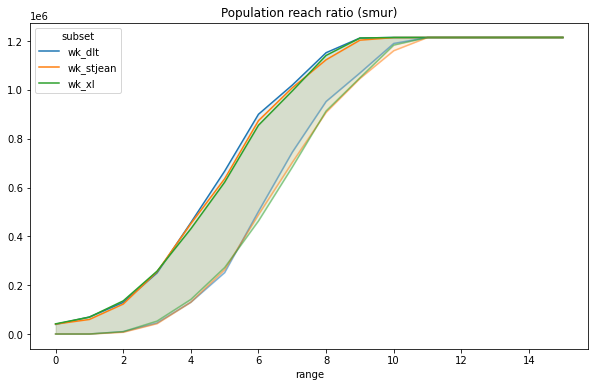

In [105]:
pv_pop_max=isolines_grouped_pop.pivot(index="range", values="POP_intersects", columns= "subset").fillna(0) #["label", "traffic"])#
pv_pop_min=isolines_grouped_pop.pivot(index="range", values="POP_contains", columns= "subset").fillna(0) #["label", "traffic"])#


ax = pv_pop_max.plot(figsize=(10, 6), title=f"Population reach ratio ({dataset}{', '+option if option else ''})")
pv_pop_min.fillna(0).plot(ax=ax, alpha=0.5, color=["C0", "C1", "C2", "C3"], legend=False)

for c in range(pv_pop_min.shape[1]):
    ax.fill_between(pv_pop_max.index, pv_pop_max.iloc[:,c], pv_pop_min.iloc[:,c], color=f"C{c}", alpha=0.1)
plt.savefig(f"{output_path}/pop_reach_ratio_{dataset_label}.png") #set_index("label", "range").reach_ratio.plot()


In [106]:
isolines_grouped_pop

range     subset           label  \
0       0      wk_xl       wk_xl (0)   
1       1      wk_xl       wk_xl (1)   
2       2      wk_xl       wk_xl (2)   
3       3      wk_xl       wk_xl (3)   
4       4      wk_xl       wk_xl (4)   
5       5      wk_xl       wk_xl (5)   
6       6      wk_xl       wk_xl (6)   
7       7      wk_xl       wk_xl (7)   
8       8      wk_xl       wk_xl (8)   
9       9      wk_xl       wk_xl (9)   
10     10      wk_xl      wk_xl (10)   
11     11      wk_xl      wk_xl (11)   
12     12      wk_xl      wk_xl (12)   
13     13      wk_xl      wk_xl (13)   
14     14      wk_xl      wk_xl (14)   
15     15      wk_xl      wk_xl (15)   
16      0     wk_dlt      wk_dlt (0)   
17      1     wk_dlt      wk_dlt (1)   
18      2     wk_dlt      wk_dlt (2)   
19      3     wk_dlt      wk_dlt (3)   
20      4     wk_dlt      wk_dlt (4)   
21      5     wk_dlt      wk_dlt (5)   
22      6     wk_dlt      wk_dlt (6)   
23      7     wk_dlt      wk_dlt (7)   
24      8     wk_dlt      wk_dlt (8)   
25      9     wk_dlt      wk_dlt (9)   
26     10     wk_dlt     wk_dlt (10)   
27     11     wk_dlt     wk_dlt (11)   
28     12     wk_dlt     wk_dlt (12)   
29     13     wk_dlt     wk_dlt (13)   
30     14     wk_dlt     wk_dlt (14)   
31     15     wk_dlt     wk_dlt (15)   
32      0  wk_stjean   wk_stjean (0)   
33      1  wk_stjean   wk_stjean (1)   
34      2  wk_stjean   wk_stjean (2)   
35      3  wk_stjean   wk_stjean (3)   
36      4  wk_stjean   wk_stjean (4)   
37      5  wk_stjean   wk_stjean (5)   
38      6  wk_stjean   wk_stjean (6)   
39      7  wk_stjean   wk_stjean (7)   
40      8  wk_stjean   wk_stjean (8)   
41      9  wk_stjean   wk_stjean (9)   
42     10  wk_stjean  wk_stjean (10)   
43     11  wk_stjean  wk_stjean (11)   
44     12  wk_stjean  wk_stjean (12)   
45     13  wk_stjean  wk_stjean (13)   
46     14  wk_stjean  wk_stjean (14)   
47     15  wk_stjean  wk_stjean (15)   

                                             geometry  reach_ratio  \
0   MULTIPOLYGON Z (((486617.235 6587097.114 0.000...     0.004646   
1   MULTIPOLYGON Z (((485547.121 6586855.258 0.000...     0.013407   
2   MULTIPOLYGON Z (((484782.690 6586855.258 0.000...     0.042019   
3   MULTIPOLYGON Z (((473947.741 6589516.591 0.000...     0.096851   
4   MULTIPOLYGON Z (((472494.982 6589516.591 0.000...     0.190083   
5   MULTIPOLYGON Z (((472712.237 6589717.948 0.000...     0.312766   
6   MULTIPOLYGON Z (((472712.249 6589717.961 0.000...     0.460258   
7   MULTIPOLYGON Z (((493847.859 6599863.456 0.000...     0.603530   
8   MULTIPOLYGON Z (((476383.861 6597613.396 0.000...     0.755825   
9   POLYGON Z ((493458.328 6587671.704 0.000, 4934...     0.866238   
10  MULTIPOLYGON Z (((497631.138 6585740.195 0.000...     0.928253   
11  POLYGON Z ((496152.752 6585887.730 0.000, 4960...     0.974757   
12  POLYGON Z ((489682.282 6580405.144 0.000, 4896...     0.980481   
13  POLYGON Z ((497467.835 6584120.443 0.000, 4974...     0.998654   
14  POLYGON Z ((489588.838 6580361.678 0.000, 4895...     0.999275   
15  POLYGON Z ((497628.543 6584188.983 0.000, 4970...     1.000000   
16  MULTIPOLYGON Z (((486617.235 6587097.114 0.000...     0.005697   
17  MULTIPOLYGON Z (((485547.121 6586855.258 0.000...     0.015891   
18  MULTIPOLYGON Z (((474253.536 6589032.744 0.000...     0.046508   
19  MULTIPOLYGON Z (((473947.741 6589516.591 0.000...     0.101163   
20  MULTIPOLYGON Z (((472494.982 6589516.591 0.000...     0.200873   
21  MULTIPOLYGON Z (((472712.237 6589717.948 0.000...     0.345029   
22  MULTIPOLYGON Z (((472712.249 6589717.961 0.000...     0.522135   
23  MULTIPOLYGON Z (((493847.859 6599863.456 0.000...     0.673726   
24  MULTIPOLYGON Z (((476383.861 6597613.396 0.000...     0.813096   
25  POLYGON Z ((495744.934 6588548.750 0.000, 4956...     0.905713   
26  POLYGON Z ((489800.414 6580460.094 0.000, 4897...     0.969368   
27  POLYGON Z ((489800.414 6580460.094 0.000, 4897...     0.998704   
28  POLYGON Z

## Beter average

In [107]:
nb_levels=5

geo_df_levels = None

def get_crossed_sectors(geo_df, shape):
    """
    Compute which polygons of geo_df are crossed by shape

    Parameters
    ----------
    geo_df: geopandas.GeoDataFrame
       a GeoDataFrame with a string column "CD_SECTOR" 
    shape: shapely.geometry.linestring.LineString
       a line corresponding typically to a geofg.loc[i].geometry.boundary
       
    Returns
    -------

    pd.Series of boolean, with geo_df.shape[0] rows
    """

    # Simple version. Might be very long, especially for "maternity" use case 
    # return pop_per_sector_geo.geometry.crosses(shape)

    # Hierarchical version. Should be much more efficient
    # First tries to see which high level boundaries such as provinces are crossed by "shape". 
    # Then, only within those "crossed" provinces, see which districts are crossed by "shape", ..., down to statistical sectors
    
    global geo_df_levels
    if geo_df_levels is None:
        geo_df_levels = multilevel_split(geo_df)
    
    ppsg = geo_df_levels[0]
    
    for i in tqdm(range(nb_levels), leave=False):
        crosses = ppsg.geometry.crosses(shape)

        ppsg = ppsg[crosses]
        if i < nb_levels-1:
            ppsg = gpd.GeoDataFrame(ppsg[[f"CD_{i}"]].merge(geo_df_levels[i+1]))

    return geo_df.CD_SECTOR.isin(ppsg[f"CD_{nb_levels-1}"])


In [108]:
# Multilevels
# Group sectors in several levels of larger sections

def multilevel_split(geo_df):
    geo_df = geo_df.assign(CD_0 = geo_df.CD_SECTOR.str[0:2],
                           CD_1 = geo_df.CD_SECTOR.str[0:4],
                           CD_2 = geo_df.CD_SECTOR.str[0:6],
                           CD_3 = geo_df.CD_SECTOR.str[0:7],
                           CD_4 = geo_df.CD_SECTOR)

    geo_df_levels= {}
    for i in tqdm(range(nb_levels), leave=False, desc="Getting multilevel split..."):
        df = geo_df.dissolve(f"CD_{i}")[["geometry"]].reset_index()
        if i > 0:
            df = df.merge(geo_df[[f"CD_{i-1}", f"CD_{i}"]].drop_duplicates()) 
        geo_df_levels[i] = df
    return geo_df_levels

In [109]:
if from_files:
    isolines_grouped_pop = pd.read_pickle(f"data/isolines_reach_pop_{dataset_label}.pkl.gz")
else: 
    
    
    for i in tqdm(isolines_grouped_pop.index):
        isoline_sel=isolines_grouped_pop.loc[i].geometry
    #     crosses = pop_per_sector_geo.simplify(1000).geometry.crosses(isoline_sel.simplify(1000).boundary)
        crosses = get_crossed_sectors(pop_per_sector_geo, isoline_sel.buffer(security_buffer).boundary)

        isolines_grouped_pop.loc[i, "POP_crossed"] = pop_per_sector_geo[crosses].POPULATION.sum()
        common_part = pop_per_sector_geo[crosses].intersection(isoline_sel)#.plot()
        covered_ratio = common_part.area / pop_per_sector_geo[crosses].area
        covered_pop = int((pop_per_sector_geo[crosses].POPULATION * covered_ratio).sum())

        isolines_grouped_pop.loc[i, "POP_mean"] = isolines_grouped_pop.POP_contains.fillna(0).loc[i] + covered_pop
    isolines_grouped_pop.to_pickle(f"data/isolines_reach_pop_{dataset_label}.pkl.gz")

  0%|          | 0/48 [00:00<?, ?it/s]

Getting multilevel split...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [110]:
# Solid line: assumes population is uniformly spread accross all sectors
# Top fill: assumes we reach all the population of a sector as soon as the isolines cross the sector (best case assumption)
# Bottom fill: assumes we reach no one in a sector before the full sector is included in the isoline (worst case assumption)

pv_pop_max= isolines_grouped_pop.pivot(index="range", values="POP_intersects", columns= "subset").fillna(0) / pop_per_sector_geo.POPULATION.sum()
pv_pop_min= isolines_grouped_pop.pivot(index="range", values="POP_contains",   columns= "subset").fillna(0) / pop_per_sector_geo.POPULATION.sum()
pv_pop_mean=isolines_grouped_pop.pivot(index="range", values="POP_mean",       columns= "subset").fillna(0) / pop_per_sector_geo.POPULATION.sum()

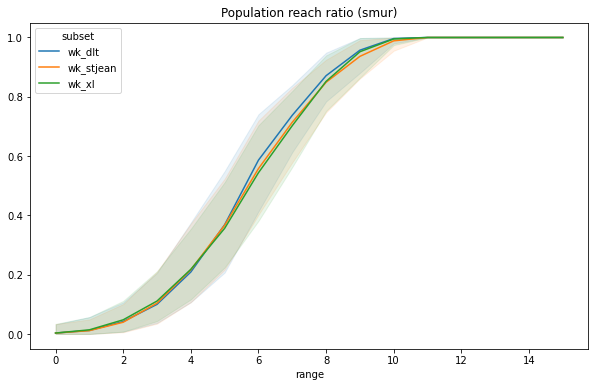

In [111]:
# With Matplotlib
ax = pv_pop_mean.plot(figsize=(10, 6), title=f"Population reach ratio ({dataset}{', '+option if option else ''})") #set_index("label", "range").reach_ratio.plot()

for c in range(pv_pop_mean.shape[1]):
     ax.fill_between(pv_pop_max.index, pv_pop_max.iloc[:,c], pv_pop_min.iloc[:,c], color=f"C{c}", alpha=0.1)
plt.savefig(f"{output_path}/pop_reach_mean_ratio_{dataset_label}.png") #set_index("label", "range").reach_ratio.plot()

In [112]:
# With Plotly express
fig = go.Figure()
for subs, color in zip(pv_pop_mean.columns[::-1], ["44, 160, 44", "255, 127, 14",  "31, 119, 180", "255,0,0"]):
    
    fig.add_trace(
        go.Scatter(
            name=f'{subs} (mean)',
            x=pv_pop_mean.index,
            y=pv_pop_mean[subs],
            mode='lines',
            line=dict(color=f'rgb({color})'),
        ))
    fig.add_trace(    go.Scatter(
            name=f'{subs} (UB)',
            x=pv_pop_max.index,
            y=pv_pop_max[subs],
            mode='lines',
            marker=dict(color=f'rgb({color})'),
            line=dict(width=0),
            showlegend=False
        ))#,
    fig.add_trace(    go.Scatter(
            name=f'{subs} (LB)',
            x=pv_pop_min.index,
            y=pv_pop_min[subs],
            marker=dict(color=f'rgb({color})'),
            line=dict(width=0),
            mode='lines',
            fillcolor=f'rgba({color}, 0.2)',
       
            fill='tonexty',
            showlegend=False
        ))
# ])
fig.update_layout(
    yaxis_title='Reached population (ratio)',
    xaxis_title='Range (minutes)',
    title=f"Population reach ratio ({dataset}{', '+option if option else ''})",
    hovermode="x",
    yaxis_tickformat= ',.2%',
)

fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
fig.show()
fig.write_html(f"{output_path}/pop_reach_mean_ratio_{dataset_label}.html",include_plotlyjs="cdn" ) #set_index("label", "range").reach_ratio.plot()

## Plots for blog


In [113]:
# Works for "Vaccin", no traffic

if dataset == "vaccin" and option is None:
    aud_wb = statistical_sectors[statistical_sectors.T_MUN_FR.isin(["Auderghem", "Watermael-Boitsfort"])].copy()
    il = isolines[(isolines.name == "Watermael") & (isolines.range==3)]


    aud_wb["color"] = "red"
    aud_wb.loc[aud_wb.crosses(il.boundary.iloc[0]), "color"] ="orange"
    aud_wb.loc[aud_wb.within(il.iloc[0].geometry), "color"] ="green"

    ax = aud_wb.plot(figsize=(10,10), edgecolor="black", color=aud_wb.color, alpha=0.2)


    il.boundary.plot(ax=ax, color="blue")
    plt.axis('off')
    plt.savefig(f"{output_path}/crosses.png")

Proportion of 'Forêt de Soignes' in Brussels: 10.09%


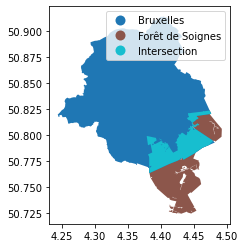

In [114]:
def get_osm_polyg(name):
    url = f"http://nominatim.openstreetmap.org/search.php?q={name}&format=json&limit=1&polygon_geojson=1"
    with urllib.request.urlopen(url) as response:
        return shape(json.loads(response.read())[0]["geojson"])

foret = get_osm_polyg("Foret+de+Soignes")
bxl = get_osm_polyg("Bruxelles-Capitale")
inters = bxl.intersection(foret)
df =  gpd.GeoDataFrame([{"name":"Forêt de Soignes", "geometry": foret},
                        {"name":"Bruxelles", "geometry": bxl},
                        {"name":"Intersection", "geometry": inters}])
df = df.set_geometry("geometry")
df.crs = osm_crs 
df.plot("name", legend=True)
print(f"Proportion of 'Forêt de Soignes' in Brussels: {inters.area/bxl.area:.02%}")